In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
conn = sqlite3.connect('C:/Users/amit.prakash/Documents/Python/Python/Amazon Food/database.sqlite')
filtered_data = pd.read_sql_query(''' SELECT * FROM REVIEWS LIMIT 100000''', conn)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = int(df[df['Score']==1].shape[0]);
    negCount = int(df[df['Score']==0].shape[0]);
    if negCount < posCount:
        return negCount
    return posCount

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Performing Downsampling
# samplingCount = findMinorClassPoints(filtered_data)
# postive_df = filtered_data[filtered_data['Score'] == 1].sample(n=5000)
# negative_df = filtered_data[filtered_data['Score'] == 0].sample(n=5000)

# filtered_data = pd.concat([postive_df, negative_df])

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."


In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

#Removing the anamolies
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


preprocessed_reviews = []

for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

100%|█████████████████████████████████████████████████████████████████████████| 88461/88461 [00:02<00:00, 37321.15it/s]


In [4]:
X = final['CleanedText']
y = final['Score']

In [5]:
del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data

In [6]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (56614,)
Shape of Output - Train: (56614,)
Shape of Input  - CV   : (14154,)
Shape of Output - CV   : (14154,)
Shape of Input  - Test : (17693,)
Shape of Output - Test : (17693,)


In [7]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[571, 289, 9, 285, 3041, 5, 42, 744, 333, 16, 152, 182, 115, 2, 433, 1, 687, 3, 861, 5, 546, 2506, 2535, 3042, 211, 3, 193, 1235, 349, 357, 546, 1634, 258, 3, 193, 1235, 349, 357]
56614


In [8]:
max_review_length = 1000
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(56614, 1000)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

# LSTM with 1 layer and 5 epochs

In [9]:
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

Instructions for updating:
Colocations handled automatically by placer.
***********************************************
Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


In [10]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

Instructions for updating:
Use tf.cast instead.
Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - ETA: 22:48 - loss: 0.6930 - acc: 0.53 - ETA: 22:03 - loss: 0.6901 - acc: 0.69 - ETA: 22:14 - loss: 0.6874 - acc: 0.73 - ETA: 23:10 - loss: 0.6845 - acc: 0.76 - ETA: 23:46 - loss: 0.6811 - acc: 0.77 - ETA: 25:12 - loss: 0.6771 - acc: 0.78 - ETA: 26:42 - loss: 0.6723 - acc: 0.79 - ETA: 27:06 - loss: 0.6670 - acc: 0.80 - ETA: 27:07 - loss: 0.6602 - acc: 0.81 - ETA: 27:21 - loss: 0.6531 - acc: 0.81 - ETA: 27:31 - loss: 0.6428 - acc: 0.81 - ETA: 27:41 - loss: 0.6289 - acc: 0.82 - ETA: 27:55 - loss: 0.6135 - acc: 0.82 - ETA: 28:11 - loss: 0.6143 - acc: 0.82 - ETA: 28:18 - loss: 0.6071 - acc: 0.82 - ETA: 28:30 - loss: 0.5960 - acc: 0.82 - ETA: 28:41 - loss: 0.5839 - acc: 0.83 - ETA: 28:53 - loss: 0.5751 - acc: 0.83 - ETA: 29:08 - loss: 0.5669 - acc: 0.83 - ETA: 29:23 - loss: 0.5591 - acc: 0.83 - ETA: 29:54 - loss: 0.5539 - acc: 0.83 - ETA: 

56614/56614 [==============================] - ETA: 2:06:53 - loss: 0.1320 - acc: 0.95 - ETA: 2:08:04 - loss: 0.1435 - acc: 0.94 - ETA: 2:06:35 - loss: 0.1513 - acc: 0.94 - ETA: 2:06:40 - loss: 0.1511 - acc: 0.94 - ETA: 2:06:33 - loss: 0.1533 - acc: 0.94 - ETA: 2:04:23 - loss: 0.1510 - acc: 0.94 - ETA: 2:02:30 - loss: 0.1471 - acc: 0.94 - ETA: 2:00:52 - loss: 0.1472 - acc: 0.94 - ETA: 1:59:25 - loss: 0.1463 - acc: 0.94 - ETA: 1:58:10 - loss: 0.1493 - acc: 0.94 - ETA: 1:57:44 - loss: 0.1511 - acc: 0.94 - ETA: 1:55:56 - loss: 0.1521 - acc: 0.94 - ETA: 1:54:57 - loss: 0.1517 - acc: 0.94 - ETA: 1:53:30 - loss: 0.1499 - acc: 0.94 - ETA: 1:52:29 - loss: 0.1531 - acc: 0.94 - ETA: 1:51:29 - loss: 0.1524 - acc: 0.94 - ETA: 1:50:38 - loss: 0.1528 - acc: 0.94 - ETA: 1:49:07 - loss: 0.1527 - acc: 0.94 - ETA: 1:47:41 - loss: 0.1548 - acc: 0.94 - ETA: 1:46:32 - loss: 0.1566 - acc: 0.93 - ETA: 1:45:14 - loss: 0.1567 - acc: 0.93 - ETA: 1:44:19 - loss: 0.1575 - acc: 0.93 - ETA: 1:43:17 - loss: 0.1575 -

17693/17693 [==============================] - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 48 - ETA: 40 - ETA: 31 - ETA: 22 - ETA: 13 - ETA: 4 - 305s 17ms/step
Test score: 0.20402363778417218
Test accuracy: 0.9207031029321661


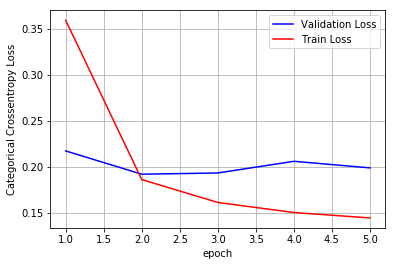

In [11]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

# LSTM with 2 layers and 10 epochs

In [12]:
embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model1.add(LSTM(100, return_sequences=True))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 100)         53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 10
batchsize = 700

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

Train on 56614 samples, validate on 14154 samples
Epoch 1/10
56614/56614 [==============================] - ETA: 2:04:19 - loss: 0.1216 - acc: 0.95 - ETA: 1:58:49 - loss: 0.1265 - acc: 0.95 - ETA: 1:56:23 - loss: 0.1276 - acc: 0.94 - ETA: 1:54:28 - loss: 0.1220 - acc: 0.95 - ETA: 1:52:17 - loss: 0.1234 - acc: 0.95 - ETA: 1:51:58 - loss: 0.1253 - acc: 0.95 - ETA: 1:50:46 - loss: 0.1243 - acc: 0.95 - ETA: 1:50:47 - loss: 0.1217 - acc: 0.95 - ETA: 1:51:08 - loss: 0.1201 - acc: 0.95 - ETA: 1:49:24 - loss: 0.1231 - acc: 0.95 - ETA: 1:47:27 - loss: 0.1224 - acc: 0.95 - ETA: 1:46:28 - loss: 0.1230 - acc: 0.95 - ETA: 1:46:30 - loss: 0.1221 - acc: 0.95 - ETA: 1:44:39 - loss: 0.1235 - acc: 0.95 - ETA: 1:43:21 - loss: 0.1249 - acc: 0.95 - ETA: 1:42:05 - loss: 0.1246 - acc: 0.95 - ETA: 1:40:41 - loss: 0.1261 - acc: 0.95 - ETA: 1:39:11 - loss: 0.1258 - acc: 0.95 - ETA: 1:37:25 - loss: 0.1270 - acc: 0.95 - ETA: 1:35:47 - loss: 0.1272 - acc: 0.95 - ETA: 1:34:09 - loss: 0.1266 - acc: 0.95 - ETA: 1:32:

56614/56614 [==============================] - ETA: 2:19:50 - loss: 0.1181 - acc: 0.96 - ETA: 2:17:44 - loss: 0.1171 - acc: 0.95 - ETA: 2:15:56 - loss: 0.1218 - acc: 0.95 - ETA: 2:14:16 - loss: 0.1169 - acc: 0.95 - ETA: 2:12:22 - loss: 0.1135 - acc: 0.95 - ETA: 2:10:34 - loss: 0.1151 - acc: 0.95 - ETA: 2:09:04 - loss: 0.1132 - acc: 0.95 - ETA: 2:07:55 - loss: 0.1132 - acc: 0.95 - ETA: 2:06:14 - loss: 0.1144 - acc: 0.95 - ETA: 2:04:50 - loss: 0.1158 - acc: 0.95 - ETA: 2:03:15 - loss: 0.1164 - acc: 0.95 - ETA: 2:01:19 - loss: 0.1157 - acc: 0.95 - ETA: 1:59:36 - loss: 0.1173 - acc: 0.95 - ETA: 1:57:43 - loss: 0.1164 - acc: 0.95 - ETA: 1:55:58 - loss: 0.1159 - acc: 0.95 - ETA: 1:54:08 - loss: 0.1161 - acc: 0.95 - ETA: 1:52:18 - loss: 0.1148 - acc: 0.95 - ETA: 1:50:37 - loss: 0.1145 - acc: 0.95 - ETA: 1:48:45 - loss: 0.1135 - acc: 0.95 - ETA: 1:46:57 - loss: 0.1131 - acc: 0.95 - ETA: 1:45:12 - loss: 0.1143 - acc: 0.95 - ETA: 1:43:23 - loss: 0.1137 - acc: 0.95 - ETA: 1:41:35 - loss: 0.1142 -

56614/56614 [==============================] - ETA: 2:31:38 - loss: 0.0988 - acc: 0.97 - ETA: 2:30:11 - loss: 0.0919 - acc: 0.97 - ETA: 2:28:11 - loss: 0.0888 - acc: 0.97 - ETA: 2:26:01 - loss: 0.0893 - acc: 0.97 - ETA: 2:24:09 - loss: 0.0917 - acc: 0.97 - ETA: 2:22:35 - loss: 0.0915 - acc: 0.96 - ETA: 2:20:40 - loss: 0.0964 - acc: 0.96 - ETA: 2:18:47 - loss: 0.0945 - acc: 0.96 - ETA: 2:17:01 - loss: 0.0922 - acc: 0.96 - ETA: 2:15:06 - loss: 0.0924 - acc: 0.96 - ETA: 2:13:15 - loss: 0.0915 - acc: 0.96 - ETA: 2:11:19 - loss: 0.0913 - acc: 0.96 - ETA: 2:09:32 - loss: 0.0917 - acc: 0.96 - ETA: 2:07:44 - loss: 0.0908 - acc: 0.96 - ETA: 2:06:04 - loss: 0.0908 - acc: 0.96 - ETA: 2:04:12 - loss: 0.0919 - acc: 0.96 - ETA: 2:02:22 - loss: 0.0917 - acc: 0.96 - ETA: 2:00:31 - loss: 0.0925 - acc: 0.96 - ETA: 1:58:34 - loss: 0.0918 - acc: 0.96 - ETA: 1:56:39 - loss: 0.0919 - acc: 0.96 - ETA: 1:54:44 - loss: 0.0927 - acc: 0.96 - ETA: 1:52:49 - loss: 0.0928 - acc: 0.96 - ETA: 1:50:53 - loss: 0.0934 -

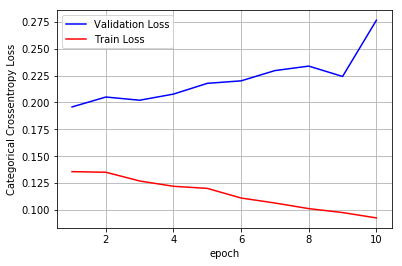

In [15]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Layer", "Epoch", "Test Accuracy"]

x.add_row([1, 5, 92.07])
x.add_row([2, 10, 91.3])



print(x)

+-------+-------+---------------+
| Layer | Epoch | Test Accuracy |
+-------+-------+---------------+
|   1   |   5   |     92.07     |
|   2   |   10  |      91.3     |
+-------+-------+---------------+


## Conclusion

The LSTM model with '1' layer and '5' epochs hives us a higher test accuracy score.